In [1]:
import sys
import numpy as np
import math
import ceo
from IPython.display import display, clear_output
%pylab inline
%run ../GMT_DOS_SAO.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
nPx = N_PX_LENSLET*N_LENSLET+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENSLET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
zenith_angle  = np.ones((1,N_GS))*zenith_distance_arcmin*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source(AGWS_photometric_band,
                   zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25],
                  magnitude=15,fwhm=10.6)
wfs = ceo.ShackHartmann(N_LENSLET, N_PX_LENSLET, lenslet_pitch_meter, 
                        N_PX_IMAGE=40,BIN_IMAGE=4,N_GS=N_GS)
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,
                 M1_radial_order=M1_zernike_radial_order,
                 M2_radial_order=M1_zernike_radial_order)
wfs.camera.photoelectron_gain = optics_throughtput

pupil sampling:      469 pixel
detector resolution: 468 pixel


In [3]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas
(81, 81)


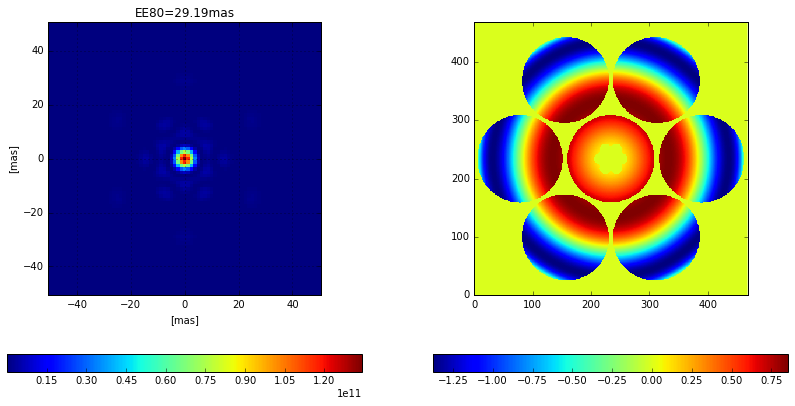

In [4]:
src = ceo.Source(S_photometric_band,
                 rays_box_size=entrance_pupil_size_meter,
                 rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
#gmt.M1.global_tiptilt(40*ceo.constants.MAS2RAD,0)
#gmt.M2.global_tiptilt(40*ceo.constants.MAS2RAD,0)
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=2*nyquist_oversampling_factor,
                   N_PX_IMAGE=detector_resolution,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(entrance_pupil_size_meter*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',
                extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)
print psf.shape

In [5]:
4*ceo.constants.ARCMIN2RAD*1e6

1163.5528346628864

# Calibrations
## Wavefront sensors

[ 4600.67529297  4601.47949219  4601.47998047]


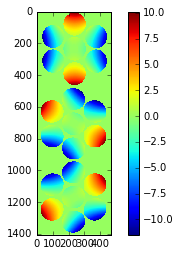

In [6]:
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [7]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/4)

(780, 260)
Pixel size: 0.264arcsec
Field of view: 2.640arcsec


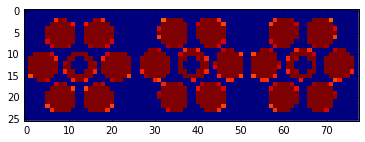

In [8]:
imshow(wfs.flux.host().T,interpolation='none')

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.14


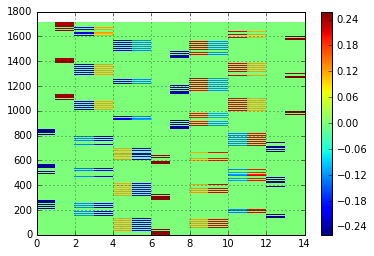

In [9]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)
M2tt = np.linalg.pinv(D2tt)

## M1 tip-tilt

___ M1 ___
Segment #:1 2 3 4 5 6 7 
------------
M1 tip-tilt interaction matrix condition #:   1.14


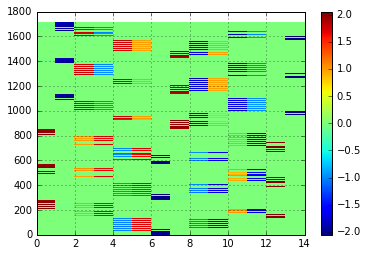

In [10]:
D1tt = gmt.calibrate(wfs,gs,mirror="M1",mode="segment tip-tilt",stroke=25*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D1tt)
colorbar(h)
grid()
print "M1 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1tt)
M1tt = np.linalg.pinv(D1tt)

## Combining M1 and M2 tip-tilt interaction matrix

M1/M2 tip-tilt interaction matrix condition #: 5786.24


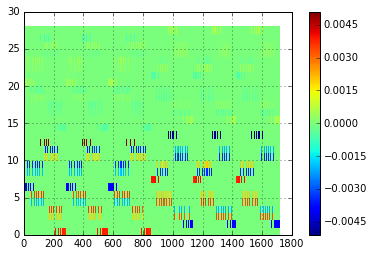

In [11]:
Dtt = np.concatenate((D1tt,D2tt),axis=1)
print "M1/M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(Dtt)
Mtt = np.linalg.pinv(Dtt,1e-3)
fig, ax = subplots()
h = ax.pcolor(Mtt)
colorbar(h)
grid()

## M1 Zernike

___ M1 ___
Segment #0: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #1: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #2: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #3: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #4: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #5: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #6: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
------------
M1 Zernike interaction matrix condition #:   5.94


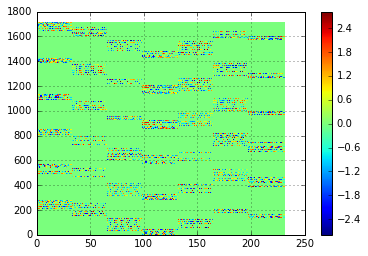

In [12]:
gmt.reset()
gs.reset()
D1z = gmt.calibrate(wfs,gs,mirror="M1",mode="zernike",stroke=1e-6)
fig, ax = subplots()
h = ax.pcolor(D1z)
colorbar(h)
grid()
print "M1 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D1z)
M1z = np.linalg.pinv(D1z)

## M2 Zernike

___ M2 ___
Segment #0: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #1: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #2: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #3: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #4: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #5: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
Segment #6: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
------------
M2 Zernike interaction matrix condition #:   5.23


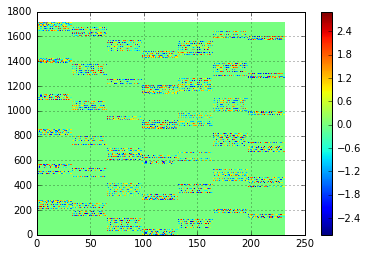

In [13]:
gmt.reset()
gs.reset()
D2z = gmt.calibrate(wfs,gs,mirror="M2",mode="zernike",stroke=1e-6)
fig, ax = subplots()
h = ax.pcolor(D2z)
colorbar(h)
grid()
print "M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D2z)
M2z = np.linalg.pinv(D2z)

## Combining M1 and M2 Zernike interaction matrix

M1/M2 Zernike interaction matrix condition #:  24.26


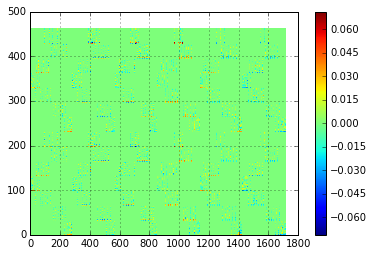

In [14]:
Dz = np.concatenate((D1z,D2z),axis=1)
print "M1/M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(Dz)
Mz = np.linalg.pinv(Dz)#,1e-3)
fig, ax = subplots()
h = ax.pcolor(Mz)
colorbar(h)
grid()

## Combining M1 and M2 tip-tilt and Zernike interaction matrix

M1/M2 Zernike interaction matrix condition #: 14639.12


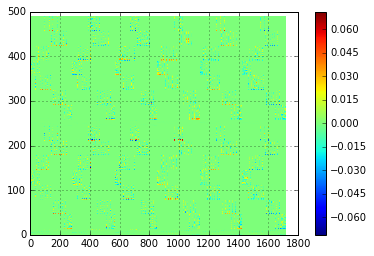

In [15]:
D = np.concatenate((D1tt,D1z,D2tt,D2z),axis=1)
print "M1/M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D)
M = np.linalg.pinv(D,1e-3)
fig, ax = subplots()
h = ax.pcolor(M)
colorbar(h)
grid()

## Perturbations

In [81]:
gmt.reset()

### M1 tip-tilt

In [31]:
gmt.M1.motion_CS.euler_angles[:,:2] = 0.1*(np.random.rand(7,2)*2-1)*ceo.constants.ARCSEC2RAD
gmt.M1.motion_CS.update()

### M1 X/Y motion

In [18]:
gmt.M1.motion_CS.origin[:,:2] = 5*(np.random.rand(7,2)*2-1)*1e-6
gmt.M1.motion_CS.update()

### M1 Zernike

In [83]:
gmt.M1.zernike.a[0,21] = 2e-6
gmt.M1.zernike.update()

In [32]:
print M1z.shape
print gmt.M1.zernike.a[:,3:].shape
control_M1_nMode = gmt.M1.zernike.n_mode - 3
gmt.M1.zernike.a[:,3:] = (np.random.rand(7,control_M1_nMode)*2-1)*0.1e-6
gmt.M1.zernike.update()

(231, 1716)
(7, 33)


### M2 tip-tilt

In [20]:
gmt.M2.motion_CS.euler_angles[:,:2] = 0.25*(np.random.rand(7,2)*2-1)*ceo.constants.ARCSEC2RAD
gmt.M2.motion_CS.update()

### M2 Zernike

In [21]:
control_M2_nMode = gmt.M2.zernike.n_mode - 3
gmt.M2.zernike.a[:,3:] = (np.random.rand(7,control_M2_nMode)*2-1)*1e-6
gmt.M2.zernike.update()

### On-axis WFE

In [84]:
src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)
print src.wavefront.rms(-9)

[ 1322.50693241]


## Closing the loop

Initial WFE rms: 1322.51nm


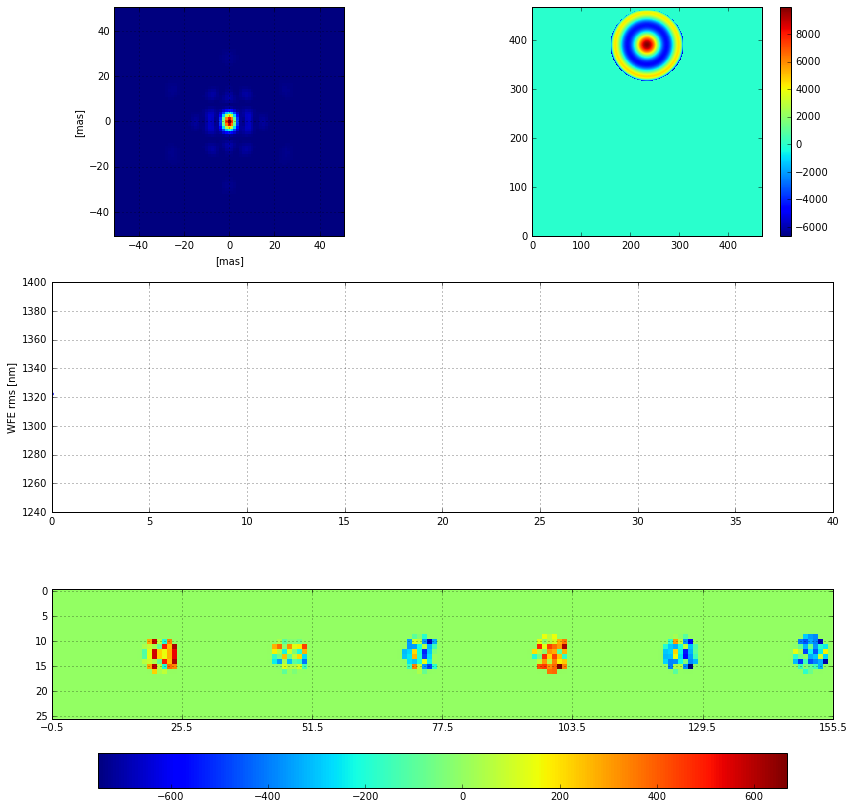

In [85]:
tid = ceo.StopWatch()
nStep = 40

gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig = figure()
fig.set_size_inches((14,14))
ax1 = plt.subplot2grid((3,2),(0,0))
ax2 = plt.subplot2grid((3,2),(0,1))
ax3  = plt.subplot2grid((3,2),(1,0), colspan=2)
ax4 = plt.subplot2grid((3,2),(2,0), colspan=2)

psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
#ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2)

wfe_rms = np.zeros(nStep+1)
wfe_rms[0] = src.wavefront.rms(-9)
h3, = ax3.plot(wfe_rms[:1],'.-')
ax3.grid()
ax3.set_ylabel("WFE rms [nm]")
ax3.set_xlim((0,nStep))
ax3.set_autoscaley_on(True)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
h4 = ax4.imshow(c,interpolation='none')
colorbar(h4,ax=ax4,orientation='horizontal')
h4.set_label("[mas]")
ax4.set_xticks(np.arange(0,N_LENSLET*(2*gs.N_SRC+1),N_LENSLET)-0.5)
ax4.grid()

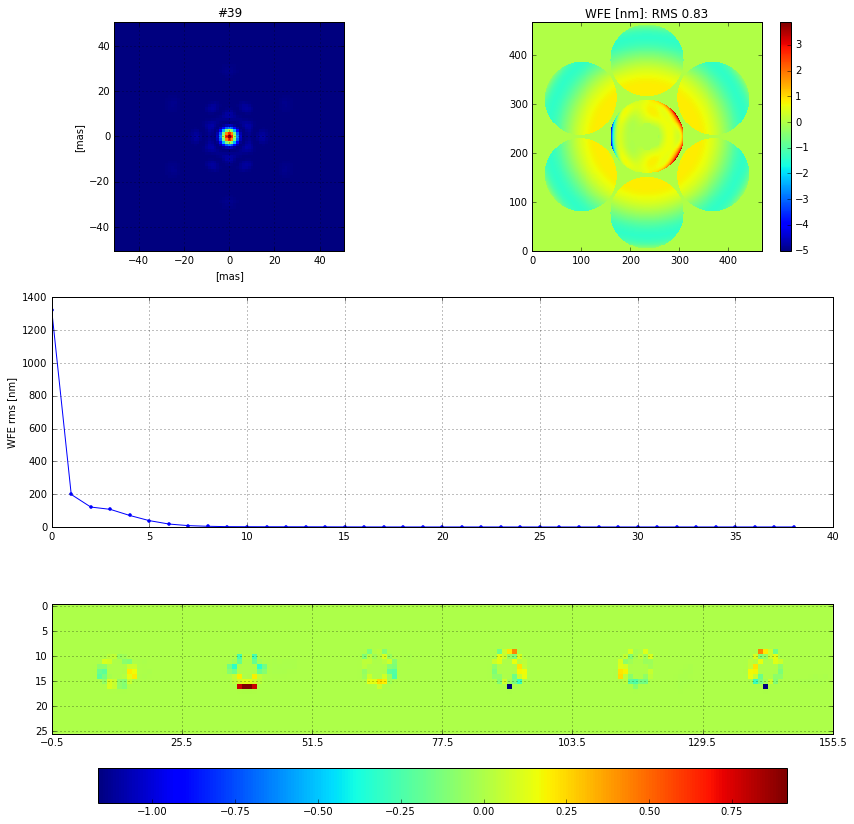

Elapsed time: 51.42s


In [86]:
idx = -1
M2_c = np.zeros((14,1))
M1_c = np.zeros((14,1))
control_M1_seg_nMode = gmt.M1.zernike.n_mode - 3
control_M1_nMode = 7*control_M1_seg_nMode
M1_za = np.zeros((control_M1_nMode,1))
control_M2_seg_nMode = gmt.M2.zernike.n_mode - 3
control_M2_nMode = 7*control_M2_seg_nMode
M2_za = np.zeros((control_M2_nMode,1))

M1_gain = 0.5
M2_gain = 0.5

tid.tic()
for kStep in range(nStep):
    
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
    
    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)
    psf = imgr.frame.host()
    
    s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
    M12_c = np.dot(M,s)
    #M12_za= np.dot(Mz,s)
    
    M1_c -= M1_gain*M12_c[:14]
    gmt.M1.motion_CS.euler_angles[:,:2] = M1_c.reshape(7,2)
    gmt.M1.motion_CS.update()
    
    M1_za -= M1_gain*M12_c[14:14+control_M1_nMode]
    gmt.M1.zernike.a[:,3:] = M1_za.reshape(7,control_M1_seg_nMode) 
    gmt.M1.zernike.update()
    
    M2_c -= M2_gain*M12_c[14+control_M1_nMode:28+control_M1_nMode]
    gmt.M2.motion_CS.euler_angles[:,:2] = M2_c.reshape(7,2)
    gmt.M2.motion_CS.update()
    
    M2_za -= M2_gain*M12_c[28+control_M1_nMode:]
    gmt.M2.zernike.a[:,3:] = M2_za.reshape(7,control_M2_seg_nMode) 
    gmt.M2.zernike.update()
    
    wfe = src.phase.host(units='nm')
    idx += 1
    idx = idx%(nStep+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()

    ax3.relim()
    ax3.autoscale_view(scaley=True)
    
    if kStep<nStep:
        h3.set_data(arange(idx),wfe_rms[:idx])
    else:
        h3.set_data(arange(nStep+1),np.roll(wfe_rms,-idx-1))
    
    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("#%d"%(kStep))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[idx])
        
    c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
    h4.set_data(c)
    h4.set_clim((c.min(),c.max()))

#    time.sleep(3)
    
    
    clear_output(wait=True)
    display(fig)
plt.close()    
tid.toc()
print "Elapsed time: %.2fs"%(1e-3*tid.elapsedTime)

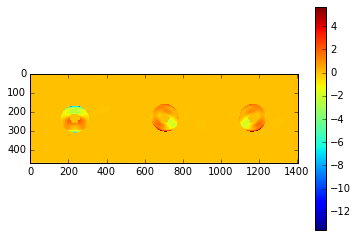

In [93]:
imshow(1e3*(gs.phase.host(units='micron')-ps0).T,interpolation='none')
colorbar()

In [99]:
a = [1,2,3]

In [100]:
len(a)

3

In [101]:
a.pop(0)

1

In [102]:
a

[2, 3]